<a href="https://colab.research.google.com/github/jonataseduardo/Admixture-Load---BEPE-project---Jonatas-Cesar/blob/master/%5BPRELIMINAR%5D%5BVIVO_ALL%5D_Seg_Audiencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PLEASE MAKE A COPY BEFORE CHANGING**

**Copyright** 2018 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


<b>Important</b>
This content are intended for educational and informational purposes only.

## Introduction 
<b>Purpose:</b> The goal of this colab is to show an example of how to calculate conversion probability. As a result we can create the feature importance report.

**Key notes**

*   This example assumes enhanced ecommerce is implemented (we are predicting transactions).
*   It is possible to adjust the query to predict a goal instead of a transaction.

**Instructions**
*   First of all: <b>MAKE A COPY</b>;
*   Fulfill the query parameters in the Box 1;
*   In the menu above click in Runtime > Run All;
*   Authorize your credentials;

## User Input (Training Query)

In [ ]:
project_id = 'project-ivanbaroni'#@param
table = 'telefonica-digitalsales.55029951.ga_sessions_*'#@param
lookback_start_date = '2020-05-20'#@param {type:"date"}
lookback_end_date = '2020-05-31'#@param {type:"date"}
conversion_window_start_date = '2020-06-01'#@param {type:"date"}
conversion_window_end_date = '2020-06-10'#@param {type:"date"}
prediction_type = 'transaction'#@param['transaction', 'event']
event_filter_type = 'eventCategory'#@param['eventCategory', 'eventAction', 'eventLabel', ' ']
event_filter_value = 'filterValue'#@param
test_size = 0.5#@param
downsample_majority_class = 0.01#@param {type:"slider", min:0.00, max:1, step:0.01}

## User Input (Classification Query)

In [ ]:
classification_start_date = '2020-06-01'#@param {type:"date"}
classification_end_date = '2020-06-10'#@param {type:"date"}
index_dimension = 'dimension58'#@param
value_dimension = 'dimension181'#@param


# Code Section

### 1 Importing libraries & setting functions

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import auth, files
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.utils import resample
from xgboost import XGBClassifier

# Display and plotting
import matplotlib.pyplot as plt
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
from IPython.display import display, HTML
import seaborn as sns; sns.set()  # for plot styling
from sklearn.cluster import KMeans

# Processing and feature selection
################################## from sklearn.preprocessing import Imputer
from sklearn import feature_extraction
from sklearn import feature_selection
from sklearn.feature_selection import RFE

# scikit learn models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# scikit learn metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score


%matplotlib inline

In [ ]:
# Function to print results
def results(X_test, Y_test, clf):
    probs = clf.predict_proba(X_test)
    auc_ = roc_auc_score(Y_test, probs[:,1])
    print("AUC: %.4f" % auc_)
    predictions = clf.predict(X_test)
    print("accuracy: %.4f" % accuracy_score(Y_test, predictions))
    print(classification_report(Y_test, clf.predict(X_test)))

# Function to plot a roc curve
def plot_roc_curve(X_test, model):
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('AdaBoosting AUC Curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Function to plot feature importance (valid for adaBoosting only)
def feature_relevance(X_test, model):
    names = X_test.columns
    feature_importance = model.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    feature_importance = feature_importance[sorted_idx]
    names = list(map(lambda x: names[x], sorted_idx))
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(20,10))
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance, align='center')
    plt.yticks(pos,names)
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    return pd.DataFrame(zip(names, feature_importance))

## 2 Importing data from Big Query

In [ ]:
# Authenticate the user to access BigQuery Projects
auth.authenticate_user()

In [ ]:
# Build the query
dc ={}
dc['project_id'] = project_id
dc['table'] = table
dc['lookback_start_date'] = lookback_start_date.replace('-', '')
dc['lookback_end_date'] = lookback_end_date.replace('-', '')
dc['conversion_window_start_date'] = conversion_window_start_date.replace('-', '')
dc['conversion_window_end_date'] = conversion_window_end_date.replace('-', '')
dc['prediction_type'] = prediction_type
dc['event_filter_type'] = event_filter_type
dc['event_filter_value'] = event_filter_value
dc['downsample_majority_class'] = downsample_majority_class
dc['classification_start_date'] = classification_start_date.replace('-', '')
dc['classification_end_date'] = classification_end_date.replace('-', '')

q = """

 WITH
  latest_session AS (
  SELECT
    * EXCEPT(rn)
  FROM (
    SELECT
      ROW_NUMBER() OVER(PARTITION BY clientid ORDER BY visitnumber DESC) AS rn,
      clientid,
      visitNumber,
      channelgrouping,
      IF(device.browser NOT IN ('Chrome', 'Safari', 'Firefox', 'Android Webview', 'Edge'), 'Others', device.browser) as browser,
      device.deviceCategory,
      IF(device.operatingSystem NOT IN('Android', 'iOS', 'Windows', 'Macintosh', 'Linux'), 'Others', device.operatingSystem ) AS operatingSystem,
      geoNetwork.region
    FROM
      `{table}`
    WHERE
      _TABLE_SUFFIX BETWEEN '{lookback_start_date}' AND '{lookback_end_date}'
      AND clientid IS NOT NULL)
  WHERE
    rn = 1 ),
 
totals as (
SELECT
    clientid,
    SUM(totals.visits) AS visits,
    SUM(totals.pageviews) AS pageviews,
    SUM(totals.hits) AS hits,
    SUM(totals.timeonsite) AS timeonsite,
    SUM(totals.bounces) AS bounces,
    SUM(CASE WHEN EXTRACT(HOUR FROM TIMESTAMP_SECONDS(visitStartTime) AT TIME ZONE "America/Sao_Paulo") IN (5,6,7,8,9,10) THEN 1 ELSE 0 END) AS morning_visits,
    SUM(CASE WHEN EXTRACT(HOUR FROM TIMESTAMP_SECONDS(visitStartTime) AT TIME ZONE "America/Sao_Paulo") IN (11,12,13,14,15,16) THEN 1 ELSE 0 END) AS daytime_visits,
    SUM(CASE WHEN EXTRACT(HOUR FROM TIMESTAMP_SECONDS(visitStartTime) AT TIME ZONE "America/Sao_Paulo") IN (17,18,19,20,21,22) THEN 1 ELSE 0 END) AS evening_visits,
    SUM(CASE WHEN EXTRACT(HOUR FROM TIMESTAMP_SECONDS(visitStartTime) AT TIME ZONE "America/Sao_Paulo") IN (23,24,0,1,2,3,4) THEN 1 ELSE 0 END) AS midnight_visits,
    SUM(totals.transactions) AS trasactions,
    SUM(totals.totalTransactionRevenue) / 100000 AS revenue
FROM
  `{table}`
WHERE
  _TABLE_SUFFIX BETWEEN '{lookback_start_date}' AND '{lookback_end_date}' AND clientid IS NOT NULL
GROUP BY 1
 
),
 
session_hits as (
SELECT
    clientid,
    SUM(CASE WHEN h.eventInfo.eventAction='tipo-aquisicao:click:radiobutton' AND h.eventInfo.eventLabel ='manter-numero' THEN 1 ELSE 0 END) AS Event01,
    SUM(CASE WHEN h.eventInfo.eventAction='tipo-aquisicao:click:radiobutton' AND h.eventInfo.eventLabel ='nova-linha' THEN 1 ELSE 0 END) AS Event02
 

 
FROM
  `{table}`, unnest(hits) h
WHERE
   _TABLE_SUFFIX BETWEEN '{lookback_start_date}' AND '{lookback_end_date}' AND clientid IS NOT NULL
GROUP BY 1),
 
converted as (
SELECT 
  *
FROM (
  SELECT 
    clientid,
    COUNT(1) AS y_conversions
  FROM
    `{table}`, UNNEST(hits) h
  WHERE
    _TABLE_SUFFIX BETWEEN '{conversion_window_start_date}' AND '{conversion_window_end_date}' AND clientid IS NOT NULL
    AND  h.eventInfo.eventLabel = 'concluir-compra'
  GROUP BY 1)
WHERE 
  y_conversions > 0
),
 
 
 
joined as(
SELECT
  sh.clientid,
  ls.channelgrouping AS last_channel,
  ls.browser,
  ls.deviceCategory,
  ls.operatingSystem,
  ls.region,
  ls.visitnumber AS current_visit,
  IFNULL(SUM(t.visits), 0) AS total_visits,
  IFNULL(SUM(t.pageviews), 0) AS total_pageviews,
  IFNULL(SUM(t.hits), 0) AS total_hits,
  IFNULL(SUM(t.timeonsite), 0) AS total_timeonsite,
  IFNULL(SUM(t.bounces), 0) AS total_bounces,
  IFNULL(SUM(t.morning_visits), 0) AS total_morning_visits,
  IFNULL(SUM(t.daytime_visits), 0) AS total_daytime_visits,
  IFNULL(SUM(t.evening_visits), 0) AS total_evening_visits,
  IFNULL(SUM(t.midnight_visits), 0) AS total_midnight_visits,
  IFNULL(SUM(t.trasactions), 0) AS total_trasactions,
 
SUM(Event01) AS Event01,
SUM(Event02) AS Event02,
  IF(IFNULL(SUM(c.y_conversions), 0) > 0, 1, 0) AS y_conversions
FROM
  session_hits sh LEFT OUTER JOIN latest_session ls
  ON sh.clientid = ls.clientid
  LEFT OUTER JOIN totals t ON sh.clientid = t.clientid
  LEFT OUTER JOIN converted c ON sh.clientid = c.clientid
GROUP BY 1,2,3,4,5,6,7)
 
SELECT * FROM joined WHERE y_conversions = 0 AND RAND() <= {downsample_majority_class} UNION ALL(SELECT * FROM joined WHERE y_conversions = 1)


""".format(**dc)

In [ ]:
# print(q)

In [ ]:
%%time
df = pd.io.gbq.read_gbq(q, project_id=project_id, verbose=False, dialect='standard')

CPU times: user 9.15 s, sys: 592 ms, total: 9.75 s
Wall time: 51.2 s


## 3 Checking and formatting dataframe

In [ ]:
print("Dataset has {} rows and {} columns".format(df.shape[0], df.shape[1]))
print()
print("Class distribution:")
print(df.y_conversions.value_counts())
print()
print("% of converters:")
print(round(df.y_conversions.value_counts()[1] /
            (df.y_conversions.value_counts()[0] + df.y_conversions.value_counts()[1])*100,2),"%")

Dataset has 151529 rows and 20 columns

Class distribution:
0    135484
1     16045
Name: y_conversions, dtype: int64

% of converters:
10.59 %


In [ ]:
df.loc[df.y_conversions == 1, :]

,clientid,last_channel,browser,deviceCategory,operatingSystem,region,current_visit,total_visits,total_pageviews,total_hits,total_timeonsite,total_bounces,total_morning_visits,total_daytime_visits,total_evening_visits,total_midnight_visits,total_trasactions,Event01,Event02,y_conversions
52419,169205351.1590513181,Organic Search,Chrome,desktop,Macintosh,State of Sao Paulo,2,2,19,39,493,0,0,2,0,0,0,0,0,1
52420,1716661724.1590771559,CRM,Chrome,mobile,Android,Federal District,1,1,8,24,363,0,0,1,0,0,0,1,0,1
52421,1472255873.1590708637,CRM,Chrome,mobile,Android,State of Sao Paulo,3,3,5,12,1078,0,0,0,2,1,0,0,0,1
52422,1996622840.1588783322,Organic Search,Chrome,mobile,Android,(not set),15,7,14,45,109,2,1,2,3,1,0,0,0,1
52423,196784276.1581608239,CRM,Others,mobile,Android,State of Sao Paulo,17,5,5,11,28,0,0,1,4,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142836,607861149.1580320459,Direct,Android Webview,mobile,Android,State of Sao Paulo,16,3,31,70,3802,0,0,0,3,0,0,8,0,1
142837,1069456193.1587069372,Paid Search,Firefox,desktop,Windows,State of Sao Paulo,3,1,5,42,227,0,1,0,0,0,0,0,0,1
142838,1763925028.1590181150,(Other),Chrome,mobile,Android,State of Rio de Janeiro,2,2,10,10,323,0,0,0,2,0,0,0,0,1
142839,1804726171.1590619800,Organic Search,Chrome,mobile,Android,State of Rio de Janeiro,3,3,23,67,1053,0,1,1,1,0,0,1,1,1


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
current_visit,151529.0,8.221073,54.913893,1.0,1.0,1.0,4.0,6170.0
total_visits,151529.0,1.830323,2.611937,0.0,1.0,1.0,2.0,139.0
total_pageviews,151529.0,6.753288,26.522732,0.0,1.0,2.0,6.0,4518.0
total_hits,151529.0,20.568063,57.752893,1.0,3.0,7.0,19.0,5196.0
total_timeonsite,151529.0,344.803351,1709.748847,0.0,0.0,19.0,219.0,182585.0
total_bounces,151529.0,0.808248,1.546548,0.0,0.0,1.0,1.0,69.0
total_morning_visits,151529.0,0.369183,0.850606,0.0,0.0,0.0,1.0,34.0
total_daytime_visits,151529.0,0.717209,1.244515,0.0,0.0,0.0,1.0,41.0
total_evening_visits,151529.0,0.617479,1.189729,0.0,0.0,0.0,1.0,40.0
total_midnight_visits,151529.0,0.179141,0.619568,0.0,0.0,0.0,0.0,31.0


In [ ]:
# df.to_csv('dataExport.csv', index=True)

In [ ]:
!pip install pandas-profiling==2.7.1

     |████████████████████████████████| 256kB 6.9MB/s 
     |████████████████████████████████| 1.1MB 8.7MB/s 
     |████████████████████████████████| 81kB 6.9MB/s 
     |████████████████████████████████| 3.1MB 18.3MB/s 
     |████████████████████████████████| 61kB 6.1MB/s 
     |████████████████████████████████| 296kB 40.1MB/s 
  Created wheel for phik: filename=phik-0.11.2-cp37-none-any.whl size=1107437 sha256=7ad2098d21ba210075ab829ce4a9b39bf0bb7d6c83d79ce0c81d458c2c921b0a
  Stored in directory: /root/.cache/pip/wheels/c0/a3/b0/f27b1cfe32ea131a3715169132ff6d85653789e80e966c3bf6
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp37-none-any.whl size=27099 sha256=0d5e991baa204121404d9756befe0b394d4c902b9b62c30a0bc77eb140c5d9a8
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
Successfully built phik htmlmin
ERROR: phik 0.11.2 has requirement scipy>=1.5.2, but you'll have scipy 1.4.1 which is incompatible.
  Found existing ins

In [ ]:
# check pandas-profiling version
!pip show pandas-profiling

# If version < 2.7, update using: 
### !pip install pandas-profiling==2.7.1

Name: pandas-profiling
Version: 2.7.1
Summary: Generate profile report for pandas DataFrame
Home-page: https://github.com/pandas-profiling/pandas-profiling
Author: Simon Brugman
Author-email: pandasprofiling@gmail.com
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: pandas, phik, confuse, jinja2, htmlmin, ipywidgets, matplotlib, numpy, missingno, joblib, visions, astropy, tangled-up-in-unicode, scipy, requests, tqdm
Required-by: 


In [ ]:
%%time
# Checking df using Pandas_Profiling

import pandas_profiling
profile = pandas_profiling.ProfileReport(df)
profile.to_file("PandasProfiling.html")

AttributeError: ignored

## 4 Data Prep

In [ ]:
# Drop the label and clientid (Xs)
X_all = df.drop(['y_conversions', 'clientid', 'region', 'operatingSystem'],1)

# Select the label to predict (Ys)
y_all = df['y_conversions']

# Get all categorical columns in a list.
text = list(X_all.select_dtypes(include=['object', 'category']).columns)

# Get all numeric columns in a list.
numbers = list(X_all.select_dtypes(include=np.number))

# Convert categoricals into the proper type
X_all.loc[:,text] = X_all.loc[:,text].astype('category')

# Stratified split into train, test sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size = test_size,
                                                    random_state = 4,
                                                    stratify = y_all)

## 5 Machine Learning Models

In [ ]:
# Build and fit the pipeline

preprocess = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), text),
    (StandardScaler(), numbers))

### 5.1 Adaptive Boosting

In [ ]:
%%time

pipe_ada = make_pipeline(
    preprocess,
    AdaBoostClassifier(n_estimators=500, learning_rate=0.1, random_state=42)
)


pipe_ada.fit(X_train,y_train)

CPU times: user 32.7 s, sys: 96.7 ms, total: 32.8 s
Wall time: 32.7 s


### 5.2 Random Forest

In [ ]:
%%time

pipe_RF = make_pipeline(
    preprocess,
    RandomForestClassifier(n_estimators=500, random_state=42)
)


pipe_RF.fit(X_train,y_train)

CPU times: user 33.9 s, sys: 403 ms, total: 34.3 s
Wall time: 34.2 s


### 5.3 Logistic Regression

In [ ]:
%%time

pipe_reg = make_pipeline(
    preprocess,
    LogisticRegressionCV(max_iter=1000)
)


pipe_reg.fit(X_train, y_train)

CPU times: user 2min 41s, sys: 13min 55s, total: 16min 36s
Wall time: 25.1 s


### 5.4 Neural Net

In [ ]:
%%time

pipe_MLP = make_pipeline(
    preprocess,
    MLPClassifier(hidden_layer_sizes=(16,8,4))
)


pipe_MLP.fit(X_train, y_train)

CPU times: user 29.3 s, sys: 118 ms, total: 29.4 s
Wall time: 29.3 s


## 6 Results

###6.1 Ada Boost

Adaboosting Results:

AUC: 0.8559
accuracy: 0.9179
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     67742
           1       0.77      0.32      0.45      8023

    accuracy                           0.92     75765
   macro avg       0.85      0.66      0.70     75765
weighted avg       0.91      0.92      0.90     75765



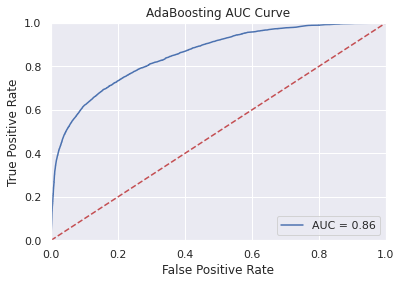

CPU times: user 31 s, sys: 499 ms, total: 31.5 s
Wall time: 31.4 s


In [ ]:
%%time
print('Adaboosting Results:')
print()

results(X_test, y_test, pipe_ada)
plot_roc_curve(X_test, pipe_ada)

### 6.2 Random Forest


Random Forest Results:

AUC: 0.8533
accuracy: 0.9162
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     67742
           1       0.68      0.39      0.50      8023

    accuracy                           0.92     75765
   macro avg       0.81      0.68      0.73     75765
weighted avg       0.90      0.92      0.91     75765



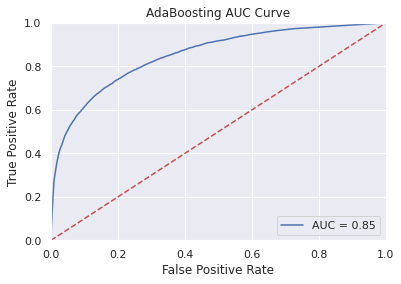

CPU times: user 33.3 s, sys: 280 ms, total: 33.6 s
Wall time: 33.5 s


In [ ]:
%%time
print('Random Forest Results:')
print()
results(X_test, y_test, pipe_RF)
plot_roc_curve(X_test, pipe_RF)

### 6.3 Logistic Regression

Logistic Regression Results:

AUC: 0.8204
accuracy: 0.9100
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     67742
           1       0.75      0.23      0.35      8023

    accuracy                           0.91     75765
   macro avg       0.83      0.61      0.65     75765
weighted avg       0.90      0.91      0.89     75765



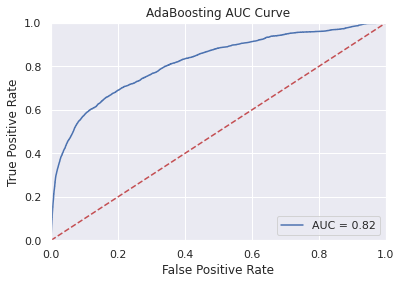

CPU times: user 3.13 s, sys: 15.9 s, total: 19.1 s
Wall time: 886 ms


In [ ]:
%%time
print('Logistic Regression Results:')
print()
results(X_test, y_test, pipe_reg)
plot_roc_curve(X_test, pipe_reg)

### 6.4 Neural Net

Neural Net Results:

AUC: 0.8701
accuracy: 0.9202
              precision    recall  f1-score   support

           0       0.93      0.98      0.96     67742
           1       0.74      0.38      0.50      8023

    accuracy                           0.92     75765
   macro avg       0.84      0.68      0.73     75765
weighted avg       0.91      0.92      0.91     75765



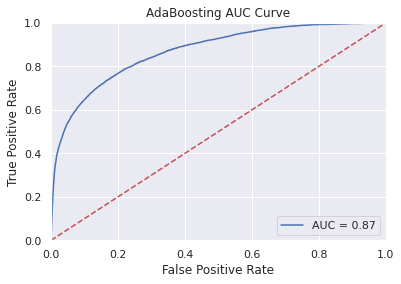

CPU times: user 3.61 s, sys: 17.5 s, total: 21.1 s
Wall time: 951 ms


In [ ]:
%%time
print('Neural Net Results:')
print()
results(X_test, y_test, pipe_MLP)
plot_roc_curve(X_test, pipe_MLP)

## 7 Classifying the new dataset

### 7.1 New Query

In [ ]:
dc ={}
dc['project_id'] = project_id
dc['table'] = table
dc['lookback_start_date'] = lookback_start_date.replace('-', '')
dc['lookback_end_date'] = lookback_end_date.replace('-', '')
dc['conversion_window_start_date'] = conversion_window_start_date.replace('-', '')
dc['conversion_window_end_date'] = conversion_window_end_date.replace('-', '')
dc['prediction_type'] = prediction_type
dc['event_filter_type'] = event_filter_type
dc['event_filter_value'] = event_filter_value
dc['downsample_majority_class'] = downsample_majority_class
dc['classification_start_date'] = classification_start_date.replace('-', '')
dc['classification_end_date'] = classification_end_date.replace('-', '')


q3 = """


WITH
  latest_session AS (
  SELECT
    * EXCEPT(rn)
  FROM (
    SELECT
      ROW_NUMBER() OVER(PARTITION BY clientid ORDER BY visitnumber DESC) AS rn,
      clientid,
      visitNumber,
      channelgrouping,
      IF(device.browser NOT IN ('Chrome', 'Safari', 'Firefox', 'Android Webview', 'Edge'), 'Others', device.browser) as browser,
      device.deviceCategory,
      IF(device.operatingSystem NOT IN('Android', 'iOS', 'Windows', 'Macintosh', 'Linux'), 'Others', device.operatingSystem ) AS operatingSystem,
      geoNetwork.region
    FROM
      `{table}`
    WHERE
      _TABLE_SUFFIX BETWEEN '{classification_start_date}' AND '{classification_end_date}'
      AND clientid IS NOT NULL)
  WHERE
    rn = 1 ),
 
totals as (
SELECT
    clientid,
    SUM(totals.visits) AS visits,
    SUM(totals.pageviews) AS pageviews,
    SUM(totals.hits) AS hits,
    SUM(totals.timeonsite) AS timeonsite,
    SUM(totals.bounces) AS bounces,
    SUM(CASE WHEN EXTRACT(HOUR FROM TIMESTAMP_SECONDS(visitStartTime) AT TIME ZONE "America/Sao_Paulo") IN (5,6,7,8,9,10) THEN 1 ELSE 0 END) AS morning_visits,
    SUM(CASE WHEN EXTRACT(HOUR FROM TIMESTAMP_SECONDS(visitStartTime) AT TIME ZONE "America/Sao_Paulo") IN (11,12,13,14,15,16) THEN 1 ELSE 0 END) AS daytime_visits,
    SUM(CASE WHEN EXTRACT(HOUR FROM TIMESTAMP_SECONDS(visitStartTime) AT TIME ZONE "America/Sao_Paulo") IN (17,18,19,20,21,22) THEN 1 ELSE 0 END) AS evening_visits,
    SUM(CASE WHEN EXTRACT(HOUR FROM TIMESTAMP_SECONDS(visitStartTime) AT TIME ZONE "America/Sao_Paulo") IN (23,24,0,1,2,3,4) THEN 1 ELSE 0 END) AS midnight_visits,
    SUM(totals.transactions) AS trasactions,
    SUM(totals.totalTransactionRevenue) / 100000 AS revenue
FROM
  `{table}`
WHERE
  _TABLE_SUFFIX BETWEEN '{classification_start_date}' AND '{classification_end_date}' AND clientid IS NOT NULL
GROUP BY 1
 
),
 
session_hits as (
SELECT
    clientid,
    SUM(CASE WHEN h.eventInfo.eventAction='tipo-aquisicao:click:radiobutton' AND h.eventInfo.eventLabel ='manter-numero' THEN 1 ELSE 0 END) AS Event01,
    SUM(CASE WHEN h.eventInfo.eventAction='tipo-aquisicao:click:radiobutton' AND h.eventInfo.eventLabel ='nova-linha' THEN 1 ELSE 0 END) AS Event02
 
 
 
FROM
  `{table}`, unnest(hits) h
WHERE
   _TABLE_SUFFIX BETWEEN '{classification_start_date}' AND '{classification_end_date}' AND clientid IS NOT NULL
GROUP BY 1),
 
 
joined as(
SELECT
  sh.clientid,
  ls.channelgrouping AS last_channel,
  ls.browser,
  ls.deviceCategory,
  ls.operatingSystem,
  ls.region,
  ls.visitnumber AS current_visit,
  IFNULL(SUM(t.visits), 0) AS total_visits,
  IFNULL(SUM(t.pageviews), 0) AS total_pageviews,
  IFNULL(SUM(t.hits), 0) AS total_hits,
  IFNULL(SUM(t.timeonsite), 0) AS total_timeonsite,
  IFNULL(SUM(t.bounces), 0) AS total_bounces,
  IFNULL(SUM(t.morning_visits), 0) AS total_morning_visits,
  IFNULL(SUM(t.daytime_visits), 0) AS total_daytime_visits,
  IFNULL(SUM(t.evening_visits), 0) AS total_evening_visits,
  IFNULL(SUM(t.midnight_visits), 0) AS total_midnight_visits,
  IFNULL(SUM(t.trasactions), 0) AS total_trasactions,
 
  SUM(Event01) AS Event01,
  SUM(Event02) AS Event02,

  FROM
  session_hits sh LEFT OUTER JOIN latest_session ls
  ON sh.clientid = ls.clientid
  LEFT OUTER JOIN totals t ON sh.clientid = t.clientid
GROUP BY 1,2,3,4,5,6,7)
 
SELECT * FROM joined



""".format(**dc)

In [ ]:
 #print(q3)

### 7.2 Classifiyng based on the NeuralNet model

In [ ]:
%%time
df2 = pd.io.gbq.read_gbq(q3, project_id=project_id, verbose=False, dialect='standard')

CPU times: user 34min 18s, sys: 16.6 s, total: 34min 35s
Wall time: 1h 45min 31s


In [ ]:
df2.columns

Index(['clientid', 'last_channel', 'browser', 'deviceCategory',
       'operatingSystem', 'region', 'current_visit', 'total_visits',
       'total_pageviews', 'total_hits', 'total_timeonsite', 'total_bounces',
       'total_morning_visits', 'total_daytime_visits', 'total_evening_visits',
       'total_midnight_visits', 'total_trasactions', 'Event01', 'Event02',
       'Event03', 'Event04', 'Event05', 'Event06', 'Event07', 'Event08',
       'Event09', 'Event10', 'Event11', 'Event12', 'Event13', 'Event14',
       'Event15'],
      dtype='object')

In [ ]:
%%time
preds = pipe_MLP.predict_proba(df2)
df2['prob'] = preds[:,1]

/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


CPU times: user 1min 13s, sys: 26 s, total: 1min 39s
Wall time: 1min


In [ ]:
df2.shape

###  7.3 Sampling for histograms

In [ ]:
# Sampling from df2
df2sample = df2.sample(frac =.03) 

In [ ]:
df2sample.shape

In [ ]:
df2sample.to_csv('sampled.csv', index=False)

### 7.4 Clustering to Score-Buckets

In [ ]:
%%time
df2['segment'] = df2.prob.apply(lambda x: 'high' if x > 0.7 else('medium' if x >0.3 else 'low'))

In [ ]:
df2.segment.value_counts()

In [ ]:
# Export final table to GA dataimport

df2cluster = df2.loc[:, ['clientid', 'segment']]
df2cluster.columns = [index_dimension, value_dimension]
df2cluster.to_csv('Final_Em_Cluster.csv', index=False)

In [ ]:
df2cluster.head()

## 8 Interpretability
 

### 8.1 Feature Importance from AdaBoosting

In [ ]:
# Using AdaBoosting for Variable Importance

cat = list(pipe_ada.named_steps.columntransformer.transformers_[0][1].get_feature_names())
features = cat + numbers
X_train = pipe_ada.named_steps.columntransformer.transform(X_train)
X_train = pd.DataFrame(X_train, columns = features)

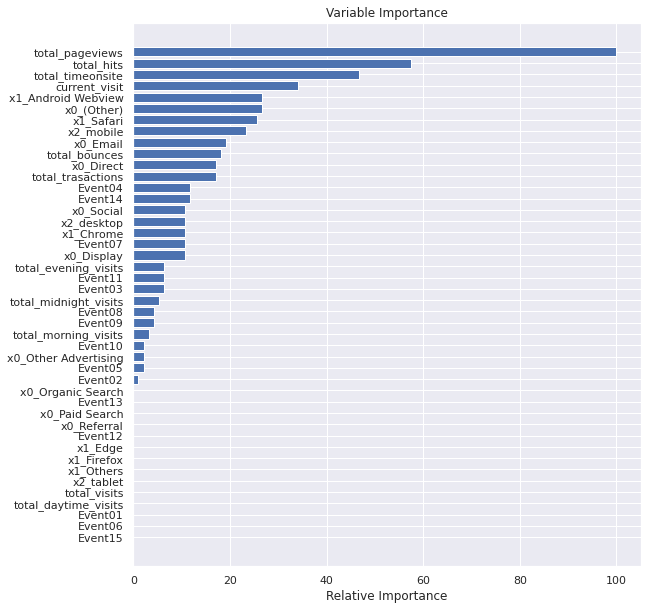

,0,1
0,Event15,0.000000
1,Event06,0.000000
2,Event01,0.000000
3,total_daytime_visits,0.000000
4,total_visits,0.000000
5,x2_tablet,0.000000
6,x1_Others,0.000000
7,x1_Firefox,0.000000
8,x1_Edge,0.000000
9,Event12,0.000000


In [ ]:
a = feature_relevance(X_train, pipe_ada.named_steps.adaboostclassifier)
a.head(20)

In [ ]:
a.to_csv('featureImportance_Ada.csv', index=False)

### 8.2 Featue Importance using SHAP

In [ ]:
!pip install shap
import shap
shap.initjs()
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline

     |████████████████████████████████| 276kB 2.1MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394139 sha256=1222218504db7d58af6aef23071085db81687a72867a8445980c890827b15112
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [ ]:
X_all = pd.get_dummies(X_all)
y_all = df['y_conversions']
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size = 0.5,
                                                    random_state = 2,
                                                    stratify = y_all)

Xb = XGBClassifier()
Xb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


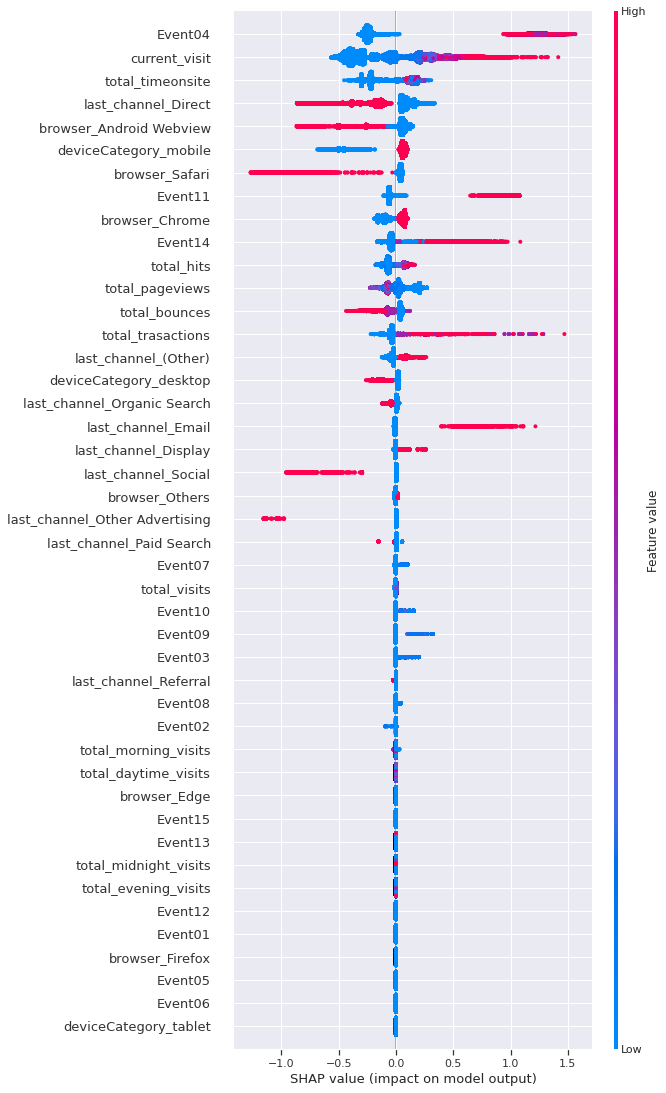

CPU times: user 1min 49s, sys: 14.6 s, total: 2min 3s
Wall time: 1min 46s


In [ ]:
%%time
def plot_shap(X_test, model):
  # Shap values
  explainer = shap.TreeExplainer(model)


  shap_values = explainer.shap_values(X_test)

  # summarize the effects of all the features
  shap.summary_plot(shap_values, X_test, max_display = 60)


plot_shap(X_train, Xb)